In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='royalblue'> Read the data (test runs below 15 seconds)

In [10]:
file_path = "E:\POSITION DATA\PRE PROCESSED/below15_runs.csv"
below15 = pd.read_csv(file_path)

In [11]:
below15.head()

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,2.989453,4.061312,1.071859
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,3.917466,4.913382,0.995917
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971
3,2019-08-08T12_41_07,NPHR1,18.0,1151.446016,T,0,1.0,NPHR,1153.832614,1154.563149,2.386598,3.117133,0.730534
4,2019-08-08T12_41_07,NPHR1,22.0,1375.846490,T,3,1.0,NPHR,1378.606669,1379.300582,2.760179,3.454093,0.693914


### <font color='royalblue'>Remove pre-illuminated and sample illuminated trials

In [12]:
below15 = below15[(below15['stim_condition']==0)|(below15['stim_condition']==3)]
below15['stim_condition'].unique()

array([3, 0], dtype=int64)

In [13]:
counts=below15.groupby(['group','stim_condition']).count()['session']
counts

group  stim_condition
CTRL   0                  954
       3                  937
NPHR   0                 1196
       3                 1164
Name: session, dtype: int64

# Latency to choice point and performance across sessions

In [19]:
# Add session numbers to each session timestamp
def add_session_nr(group):
    
    session_list = np.sort(group['session'].unique())
    i=1  
    for session in session_list:
        group.loc[group['session']==session,'session_nr']=i
        i+=1
    return group

below15= below15.groupby(['group', 'rat']).apply(add_session_nr).reset_index(drop=True)

In [34]:
%run data_prep_functions.ipynb
perfs_and_median_lats = below15.groupby(['group','session','stim_condition']).apply(calc_performance_and_median_latency_in_group)

In [35]:
perfs_and_median_lats.drop(['session', 'run_nr', 'start_timestamp','run_type', 'stim_condition', 
                            'group', 'cp_entry_timestamp', 'cp_entry_timestamp','cp_exit_timestamp', 
                            'latency_to_cp_exit', 'latency_to_cp_entry'], axis=1, inplace=True)

In [36]:
perfs_and_median_lats.reset_index(inplace=True)
perfs_and_median_lats=perfs_and_median_lats[perfs_and_median_lats['session_nr']<=15]
perfs_and_median_lats.head()

,group,session,stim_condition,level_3,rat,outcome,time_in_cp,session_nr,performance,median_latency
0,CTRL,2020-02-07T14_40_27,0,163,CTRL2,1.0,0.493171,1.0,50.000000,3.637888
1,CTRL,2020-02-07T14_40_27,3,162,CTRL2,1.0,0.861824,1.0,71.428571,3.343014
2,CTRL,2020-02-08T10_24_17,0,179,CTRL2,1.0,0.460954,2.0,71.428571,1.854938
3,CTRL,2020-02-08T10_24_17,3,177,CTRL2,1.0,0.564736,2.0,100.000000,2.712755
4,CTRL,2020-02-09T10_17_11,0,191,CTRL2,1.0,0.463603,3.0,100.000000,1.914150


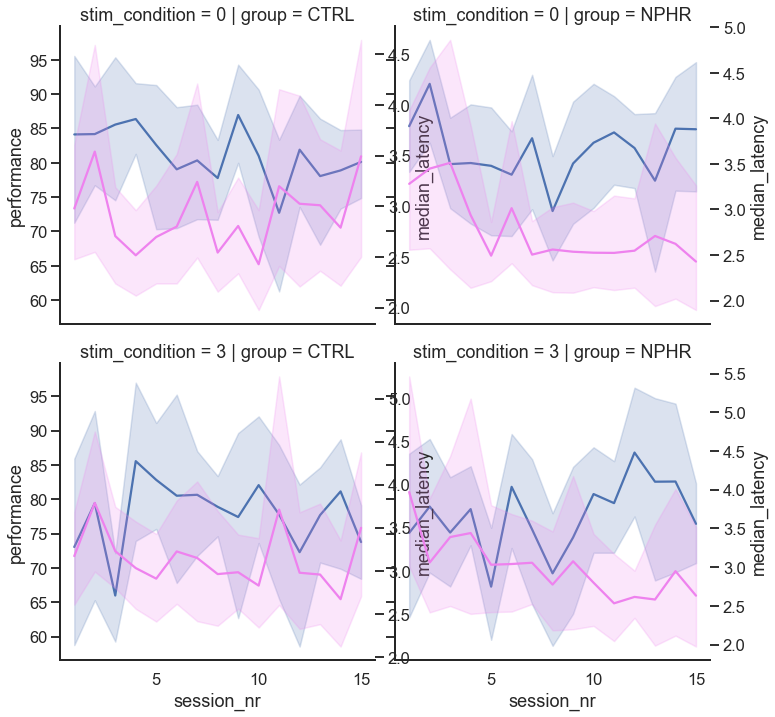

In [55]:
sns.set(style='white', context='talk')

g = sns.relplot(kind='line',col='group', row='stim_condition', data=perfs_and_median_lats, x='session_nr', y='performance')

ax = g.axes.flatten()
twins=[]
for subplot in ax:
    twin = subplot.twinx()
    twins.append(twin)

sns.lineplot(ax=twins[0], 
             data=perfs_and_median_lats[(perfs_and_median_lats['group']=='CTRL')&
                                        (perfs_and_median_lats['stim_condition']==0)], 
             x='session_nr', y='median_latency', color='violet')
sns.lineplot(ax=twins[1], 
             data=perfs_and_median_lats[(perfs_and_median_lats['group']=='NPHR')&
                                        (perfs_and_median_lats['stim_condition']==0)], 
             x='session_nr', y='median_latency', color='violet')

sns.lineplot(ax=twins[2], 
             data=perfs_and_median_lats[(perfs_and_median_lats['group']=='CTRL')&
                                        (perfs_and_median_lats['stim_condition']==3)], 
             x='session_nr', y='median_latency', color='violet')
sns.lineplot(ax=twins[3], 
             data=perfs_and_median_lats[(perfs_and_median_lats['group']=='NPHR')&
                                        (perfs_and_median_lats['stim_condition']==3)], 
             x='session_nr', y='median_latency', color='violet')

sns.despine()

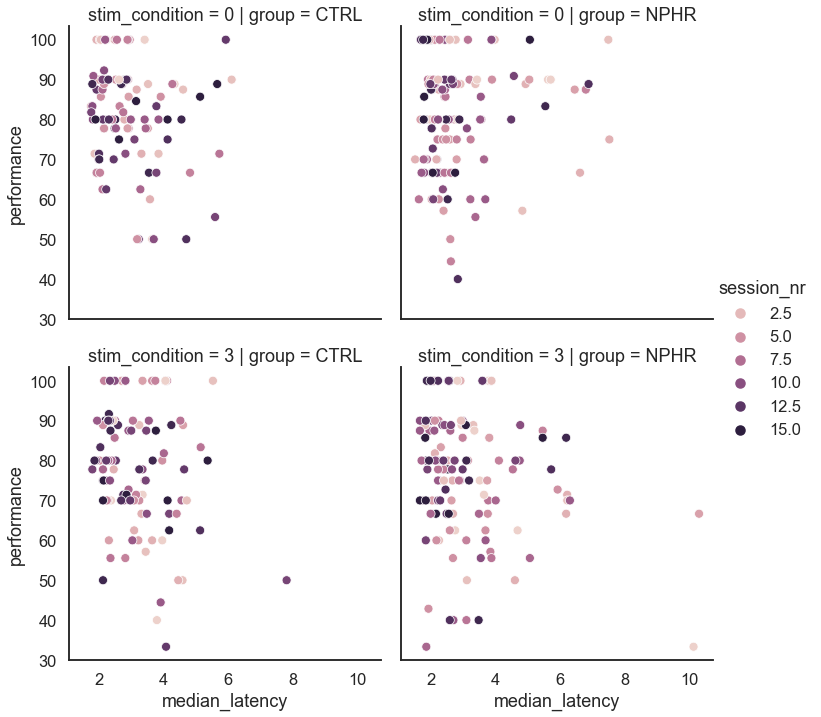

In [65]:
sns.relplot(kind='scatter', data=perfs_and_median_lats,
            col='group', row='stim_condition', y='performance', x='median_latency', hue='session_nr')

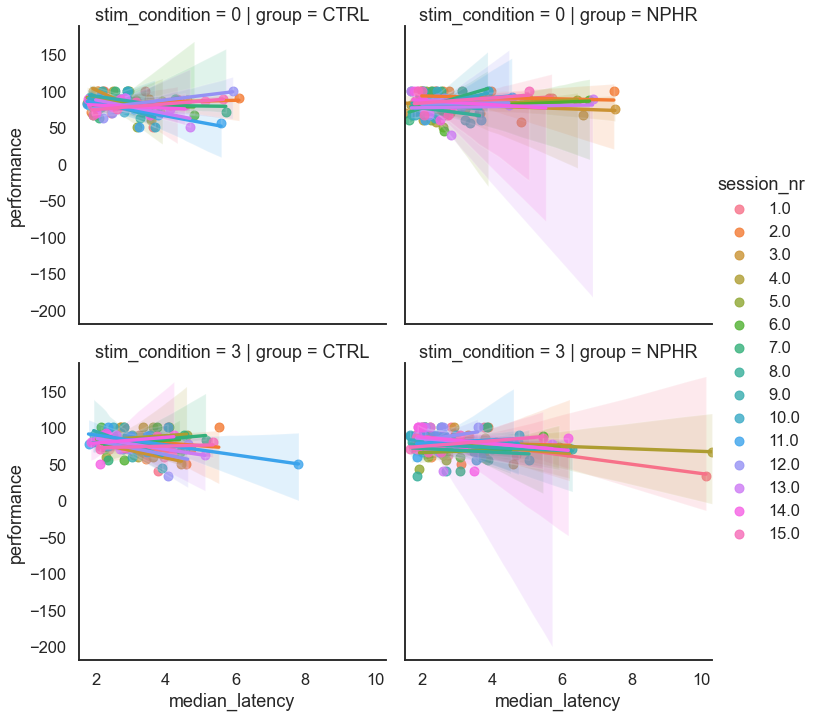

In [66]:
sns.lmplot(data=perfs_and_median_lats,
           col='group', row='stim_condition', y='performance', x='median_latency', hue='session_nr')

In [60]:
from scipy.stats import spearmanr
ctrl_no_illum = perfs_and_median_lats[(perfs_and_median_lats['group']=='CTRL')&
                                      (perfs_and_median_lats['stim_condition']==0)]
spearmanr(ctrl_no_illum['performance'],ctrl_no_illum['median_latency'])

SpearmanrResult(correlation=-0.15792890552227337, pvalue=0.10760913896704934)

In [61]:
ctrl_illum = perfs_and_median_lats[(perfs_and_median_lats['group']=='CTRL')&
                                      (perfs_and_median_lats['stim_condition']==3)]
spearmanr(ctrl_illum['performance'],ctrl_illum['median_latency'])

SpearmanrResult(correlation=-0.1781155020917168, pvalue=0.06908580294091779)

In [63]:
nphr_no_illum = perfs_and_median_lats[(perfs_and_median_lats['group']=='NPHR')&
                                      (perfs_and_median_lats['stim_condition']==0)]
spearmanr(nphr_no_illum['performance'],nphr_no_illum['median_latency'])

SpearmanrResult(correlation=0.01783798226164, pvalue=0.8360944850298171)

In [64]:
nphr_illum = perfs_and_median_lats[(perfs_and_median_lats['group']=='NPHR')&
                                      (perfs_and_median_lats['stim_condition']==3)]
spearmanr(nphr_illum['performance'],nphr_illum['median_latency'])

SpearmanrResult(correlation=-0.2476047747620708, pvalue=0.0035324454145756346)